#### Cleaning and Processing Abstract for Topic Modeling

In [1]:
import sys
import os
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import pickle

import gensim
import multiprocessing

from gensim.models import ldaseqmodel
from gensim import corpora, utils
from gensim.matutils import hellinger

from gensim.models import CoherenceModel


In [2]:
# unpack data file

with open ('../data/data_list_bert', 'rb') as fp:
    itemlist = pickle.load(fp)
    
df, documents, dictionary, corpus = itemlist  

# Make a index to word dictionary.
id2word = dictionary.id2token

In [3]:
mallet_path = '../other/mallet-2.0.8/bin/mallet' # make sure this path is updated

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [4]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=5, limit=50, step=5)

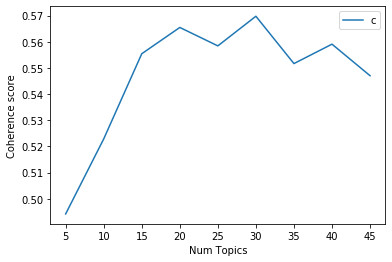

In [5]:
# Show graph
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [6]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4942
Num Topics = 10  has Coherence Value of 0.5229
Num Topics = 15  has Coherence Value of 0.5554
Num Topics = 20  has Coherence Value of 0.5654
Num Topics = 25  has Coherence Value of 0.5584
Num Topics = 30  has Coherence Value of 0.5697
Num Topics = 35  has Coherence Value of 0.5516
Num Topics = 40  has Coherence Value of 0.5591
Num Topics = 45  has Coherence Value of 0.547


In [7]:
def format_topics_sentences(model, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [8]:
df_topic_sents_keywords = format_topics_sentences(model=model_list[5], corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,26.0,0.2008,"visit, state, cost, health, ed, united, relate...","[psychiatric, related, revisit, emergency, dep..."
1,1,4.0,0.1266,"cardiac, arrest, resuscitation, cpr, survival,...","[synergistic, bradycardia, beta, blocker, hype..."
2,2,4.0,0.1450,"cardiac, arrest, resuscitation, cpr, survival,...","[lack, fetal, effect, adenosine, administratio..."
3,3,15.0,0.1351,"pain, acute, treatment, management, medication...","[compare, intranasal, ketamine, intravenous, f..."
4,4,28.0,0.0886,"intervention, community, screen, potential, se...","[involuntary, patient, length, stay, suburban,..."
5,5,19.0,0.1964,"case, report, present, death, complication, oc...","[cardioversion, pre, excited, atrial, fibrilla..."
6,6,9.0,0.1022,"present, symptom, diagnosis, stroke, history, ...","[comparison, outcome, elevation, myocardial, i..."
7,7,18.0,0.1744,"research, medicine, academic, article, consens...","[research, agenda, emergency, medicine, base, ..."
8,8,29.0,0.0857,"trial, dose, control, randomize, administratio...","[study, monitoring, emergency, care, trial, le..."
9,9,22.0,0.1534,"hospital, admission, discharge, day, rate, adm...","[analysis, emergency, physician, decision, hos..."


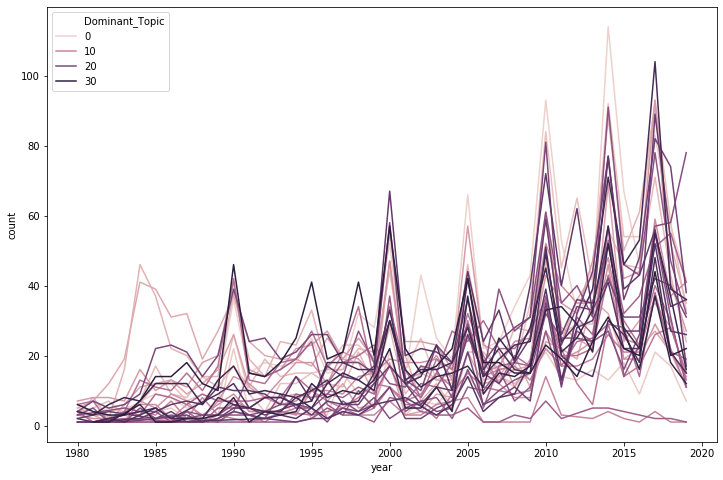

In [9]:
df_comb = pd.concat([df,df_dominant_topic], axis=1)
df_comb['count'] = 1
df_comb = df_comb.groupby(['year','Dominant_Topic']).sum()
df_comb = df_comb.reset_index()
df_comb['Dominant_Topic'] = df_comb['Dominant_Topic'].astype(int)
df_comb.head()

plt.figure(figsize=(12, 8))
sns.lineplot(x="year", y="count", hue="Dominant_Topic", data=df_comb)

In [11]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(40)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4664,"medicine, program, resident, training, medical...","[emergency, medicine, subinternship, educator,..."
1,1.0,0.4779,"datum, analysis, method, record, order, base, ...","[introduction, biostatistic, correlation, regr..."
2,2.0,0.4515,"diagnostic, diagnosis, abdominal, ultrasound, ...","[helical, scanning, primary, imaging, modality..."
3,3.0,0.5071,"intubation, airway, perform, device, ventilati...","[preliminary, evaluation, prototype, tube, val..."
4,4.0,0.5170,"cardiac, arrest, resuscitation, cpr, survival,...","[limitation, open, chest, cardiac, massage, pr..."
5,5.0,0.6481,"blood, pressure, model, flow, effect, increase...","[skeletal, muscle, metabolism, insulin, resist..."
6,6.0,0.5550,"venous, technique, access, central, catheter, ...","[oblique, view, alternative, approach, ultraso..."
7,7.0,0.4428,"injury, trauma, fracture, head, traumatic, blu...","[distracting, injury, patient, vertebral, inju..."
8,8.0,0.3325,"physician, survey, practice, report, provider,...","[float, night, year, experience, innovative, s..."
9,9.0,0.3321,"present, symptom, diagnosis, stroke, history, ...","[relationship, chief, complaint, altered, ment..."


In [13]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(50)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,8.0,"visit, length_stay, factor_associate, factor, ...",1113.0,0.0542
1,5.0,"inc_right, case, copyright_elsevi, copyright, ...",988.0,0.0481
2,23.0,"purpose_study, drug, purpose, administration, ...",652.0,0.0318
3,4.0,"child, pediatric, year, age, year_old, young, ...",526.0,0.0256
4,8.0,"visit, length_stay, factor_associate, factor, ...",564.0,0.0275
5,5.0,"inc_right, case, copyright_elsevi, copyright, ...",700.0,0.0341
6,11.0,"myocardial, acute_myocardial, acute_coronary, ...",570.0,0.0278
7,22.0,"research, academic, article, academic_emergenc...",842.0,0.0410
8,0.0,"cardiac_arrest, cardiac, arrest, resuscitation...",786.0,0.0383
9,18.0,"level, aim_study, aim, abdominal_pain, failure...",524.0,0.0255


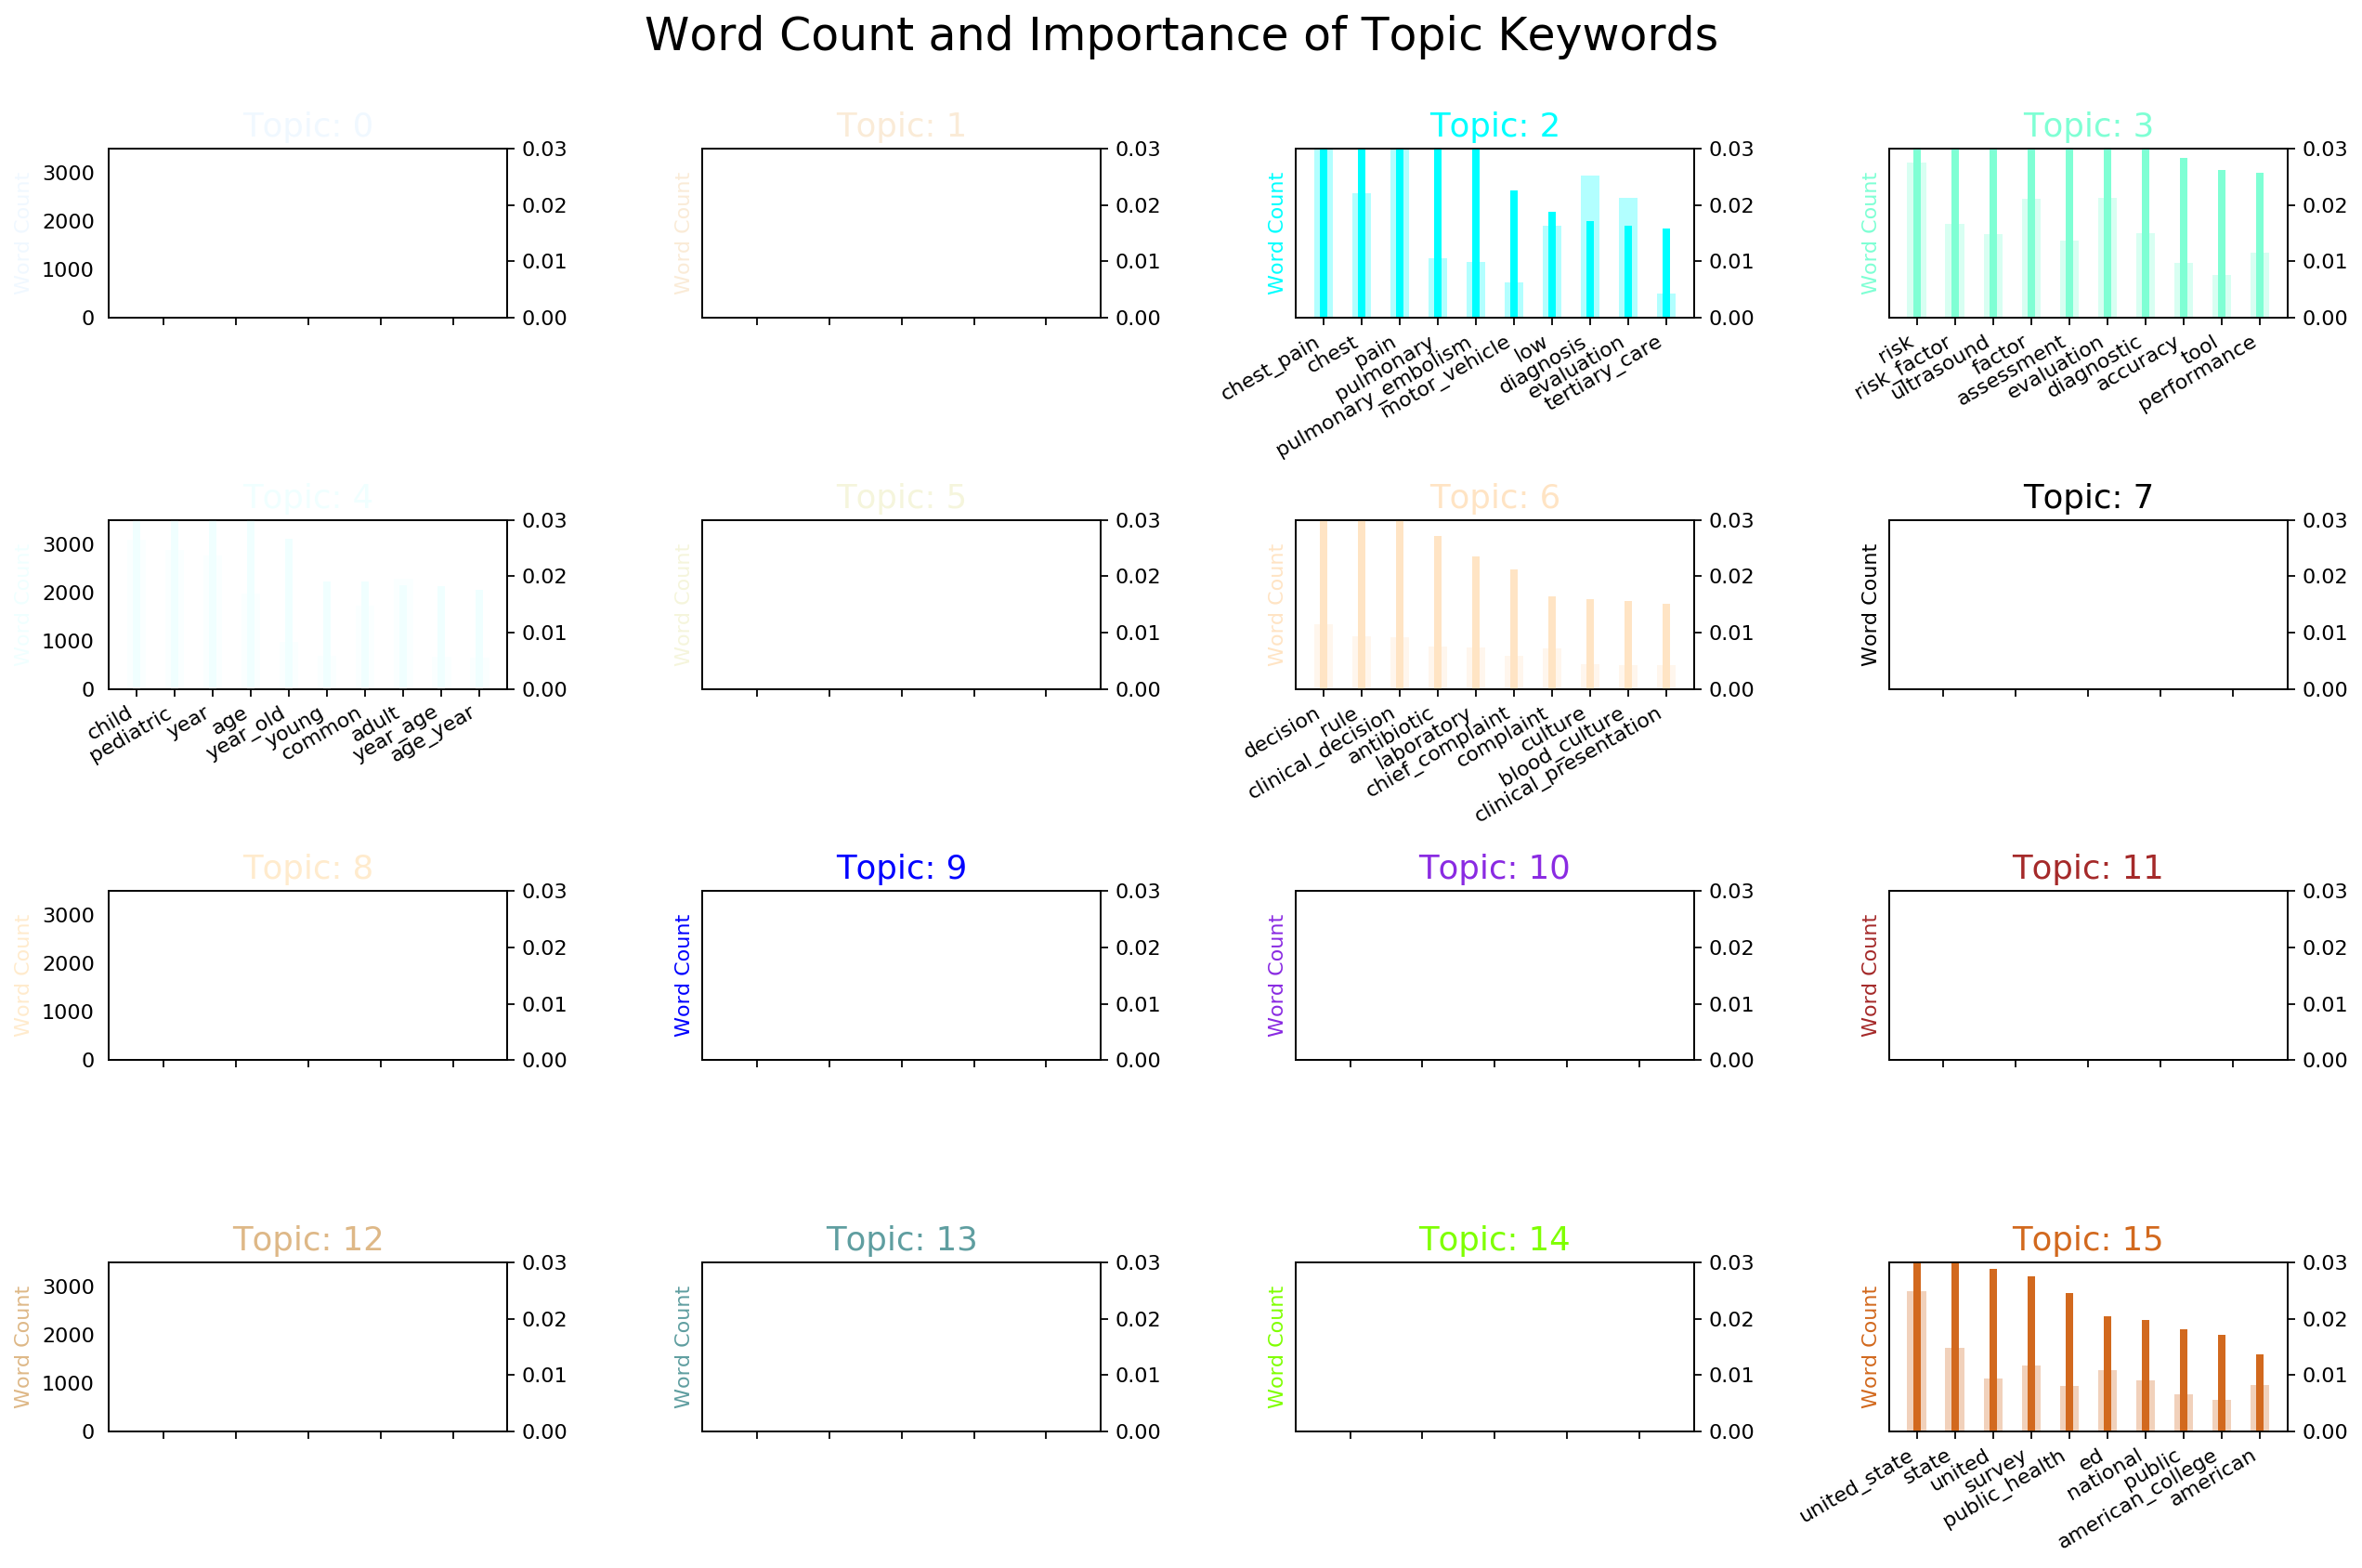

In [15]:
from collections import Counter
topics = model_list[5].show_topics(formatted=False)
data_flat = [w for w_list in documents for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.CSS4_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    #ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [18]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import numpy as np

# Get topic weights
topic_weights = []
for i, row_list in enumerate(model_list[5][corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20528 samples in 0.017s...
[t-SNE] Computed neighbors for 20528 samples in 18.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20528
[t-SNE] Computed conditional probabilities for sample 2000 / 20528
[t-SNE] Computed conditional probabilities for sample 3000 / 20528
[t-SNE] Computed conditional probabilities for sample 4000 / 20528
[t-SNE] Computed conditional probabilities for sample 5000 / 20528
[t-SNE] Computed conditional probabilities for sample 6000 / 20528
[t-SNE] Computed conditional probabilities for sample 7000 / 20528
[t-SNE] Computed conditional probabilities for sample 8000 / 20528
[t-SNE] Computed conditional probabilities for sample 9000 / 20528
[t-SNE] Computed conditional probabilities for sample 10000 / 20528
[t-SNE] Computed conditional probabilities for sample 11000 / 20528
[t-SNE] Computed conditional probabilities for sample 12000 / 20528
[t-SNE] Computed conditional probabilities for sa

In [19]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 50
mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], alpha=0.3)
show(plot)

Loading BokehJS ...

In [21]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(4, '0.085*"child" + 0.080*"pediatric" + 0.067*"year" + 0.055*"age" + 0.027*"year_old" + 0.019*"young" + 0.019*"common" + 0.018*"adult" + 0.018*"year_age" + 0.018*"age_year"'), (26, '0.050*"measure" + 0.024*"intensive_care" + 0.022*"method" + 0.021*"measurement" + 0.021*"analysis" + 0.019*"respiratory" + 0.018*"variable" + 0.017*"estimate" + 0.016*"correlation" + 0.015*"oxygen_saturation"'), (16, '0.107*"group" + 0.048*"pain" + 0.041*"receive" + 0.038*"significant_difference" + 0.034*"control" + 0.032*"difference" + 0.025*"randomize" + 0.022*"randomize_control" + 0.019*"control_group" + 0.018*"trial"'), (27, '0.041*"review" + 0.030*"design" + 0.030*"setting" + 0.029*"case" + 0.025*"conclusion" + 0.023*"retrospective" + 0.023*"participant" + 0.022*"period" + 0.020*"type" + 0.020*"measurement_main"'), (23, '0.061*"purpose_study" + 0.036*"drug" + 0.026*"purpose" + 0.018*"administration" + 0.017*"overdose" + 0.017*"seizure" + 0.016*"exposure" + 0.016*"poison" + 0.015*"activate_charcoal" +

In [ ]:
# Train LDA model.

from gensim.models import LdaModel

# Set training parameters.
num_topics = 50
chunksize = 200
passes = 20
iterations = 400


# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes)

In [ ]:



mallet_path = '../other/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_1, num_topics=50, id2word=dictionary)
ldamallet.show_topics()

In [ ]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim 


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus_1, dictionary)
vis